In [1]:
from IPython.display import clear_output
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:

    !pip install gymnasium moviepy

    clear_output()
else:
    from os import path
    sys.path.append( path.dirname( path.dirname( path.abspath("__main__") ) ) )

In [2]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
VERBOSE = True

# Configurações
NOME_AMBIENTE = "CliffWalking-v0"
EPISODIOS = 3000
TAXA_APRENDIZADO = 0.2
DESCONTO = 0.95
EPSILON = 0.1
TEMPERATURA = 1.0


In [4]:
def plot_multiple_results(resultados, log_scale=False):
    for grupo_nome, grupo_dados in resultados.items():

        plt.figure(figsize=(12, 6))
        plt.title(f"Resultados do grupo: {grupo_nome}")

        for politica_nome, recompensas in grupo_dados.items():
            plt.plot(recompensas, label=politica_nome)

        plt.xlabel("Episódios")
        plt.ylabel("Recompensas")
        if log_scale:
            plt.yscale('log')
        plt.legend()
        plt.show()

In [5]:
# Politicas

def politica_epsilon_gulosa(Q, estado, num_acoes, epsilon):
    probabilidades = [ (epsilon / num_acoes) ] * num_acoes
    acao_gulosa = np.argmax(Q[estado])
    probabilidades[acao_gulosa] += (1.0 - epsilon)
    return probabilidades

def politica_softmax(Q, estado, temperatura=1.0):
    valores_exp = np.exp(Q[estado] / temperatura)
    return valores_exp / np.sum(valores_exp)

def selecionar_acao(Q, estado, politica, **kwargs):
    probabilidades = politica(Q, estado, **kwargs)
    return np.random.choice(len(probabilidades), p=probabilidades)

In [6]:
def executar_expected_sarsa(ambiente, episodios, taxa_aprendizado=0.1, desconto=0.95,
                          politica_treinamento=politica_epsilon_gulosa, politica_alvo=politica_epsilon_gulosa,
                          parametros_politica=None, exibir=False):
    num_acoes = ambiente.action_space.n
    Q = np.zeros((ambiente.observation_space.n, num_acoes))
    recompensas_por_episodio = []

    parametros_politica = parametros_politica or {}

    for i in tqdm(range(episodios), desc="Treinando Expected-SARSA"):
        concluido = False
        recompensa_total = 0
        estado, _ = ambiente.reset()

        while not concluido:
            if exibir and (i >= (episodios - 5) or (i+1) % 1000 == 0):
                ambiente.render()

            acao = selecionar_acao(Q, estado, politica_treinamento, **parametros_politica)
            proximo_estado, recompensa, terminou, truncado, _ = ambiente.step(acao)
            concluido = terminou or truncado

            # Cálculo do valor esperado usando a política alvo
            if terminou:
                valor_proximo_estado = 0
            else:
                prob_alvo = politica_alvo(Q, proximo_estado, **parametros_politica)
                valor_proximo_estado = np.sum(prob_alvo * Q[proximo_estado])

            # Atualização Q-value
            delta = (recompensa + desconto * valor_proximo_estado) - Q[estado, acao]
            Q[estado, acao] += taxa_aprendizado * delta

            recompensa_total += recompensa
            estado = proximo_estado

        recompensas_por_episodio.append(recompensa_total)
    print("Treinamento concluído. Resultado médio: ", np.mean(recompensas_por_episodio))
    return recompensas_por_episodio, Q


In [7]:
def executar_experimentos(nome_ambiente, episodios, taxa_aprendizado, desconto, epsilon, temperatura):
    ambiente = gym.make(nome_ambiente, max_episode_steps=500)

    politicas = {
        "epsilon-gulosa": lambda Q, s, **kw: politica_epsilon_gulosa(Q, s, num_acoes=len(Q[s]), epsilon=kw['epsilon']),
        "softmax": lambda Q, s, **kw: politica_softmax(Q, s, temperatura=kw['temperatura']),
        "aleatoria": lambda Q, s, **kw: np.ones(len(Q[s])) / len(Q[s])
    }

    grupos = [
        ("1) TODOS x random", "aleatoria"),
        ("2) TODOS x epsilon-greedy", "epsilon-gulosa"),
        ("3) TODOS x softmax", "softmax")
    ]

    resultados = {}

    # Executar experimentos para cada grupo
    for nome_grupo, politica_alvo_nome in grupos:
        print(f"\n=== {nome_grupo} ===")
        grupo_resultados = {}

        for politica_treinamento_nome in politicas:
            print(f"Executando {politica_treinamento_nome} x {politica_alvo_nome}...")

            recompensas, _ = executar_expected_sarsa(
                ambiente, episodios, taxa_aprendizado, desconto,
                politicas[politica_treinamento_nome],
                politicas[politica_alvo_nome],
                {"epsilon": epsilon, "temperatura": temperatura}
            )

            grupo_resultados[f"{politica_treinamento_nome}"] = recompensas

        resultados[nome_grupo] = grupo_resultados

    # Identificar melhores de cada grupo
    final_results = {}
    for grupo_nome, grupo_dados in resultados.items():
        medias = {k: np.mean(v[-100:]) for k, v in grupo_dados.items()}  # Média dos últimos 100 episódios
        melhor = max(medias, key=medias.get)
        final_results[f"{grupo_nome} ({melhor})"] = grupo_dados[melhor]

    resultados["FINAL) Melhores de cada grupo"] = final_results

    return resultados

In [8]:
# Executar experimentos
resultados = executar_experimentos(NOME_AMBIENTE, EPISODIOS, TAXA_APRENDIZADO, DESCONTO, EPSILON, TEMPERATURA)
# clear_output()


=== 1) TODOS x random ===
Executando epsilon-gulosa x aleatoria...


Treinando Expected-SARSA:   0%|          | 2/3000 [00:00<04:30, 11.09it/s]

Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:15<00:00, 199.54it/s]


Treinamento concluído. Resultado médio:  -63.32633333333333
Executando softmax x aleatoria...


Treinando Expected-SARSA: 100%|██████████| 3000/3000 [00:07<00:00, 426.93it/s]


Treinamento concluído. Resultado médio:  -37.431
Executando aleatoria x aleatoria...


Treinando Expected-SARSA:  89%|████████▉ | 2664/3000 [01:24<00:10, 31.36it/s]


KeyboardInterrupt: 


1) TODOS x random


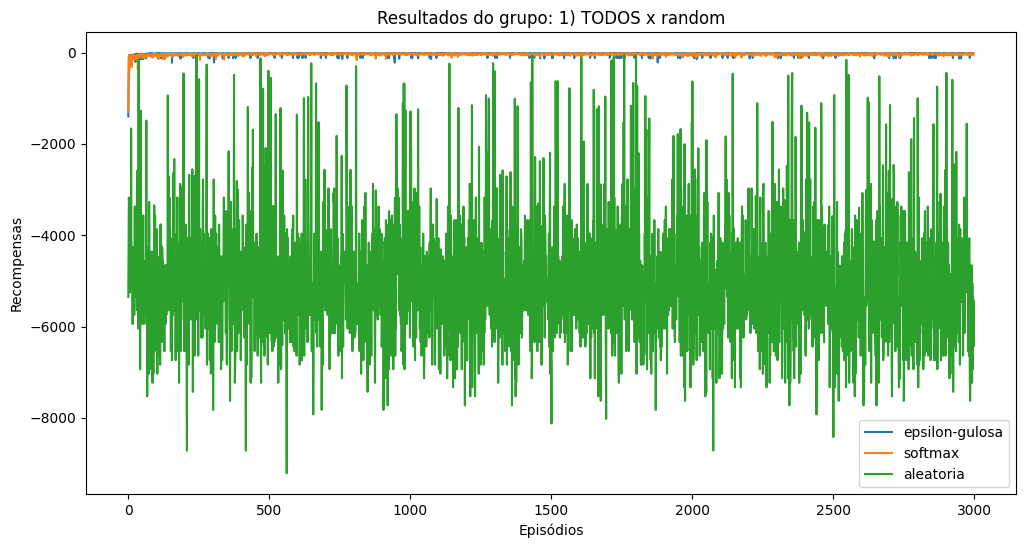


2) TODOS x epsilon-greedy


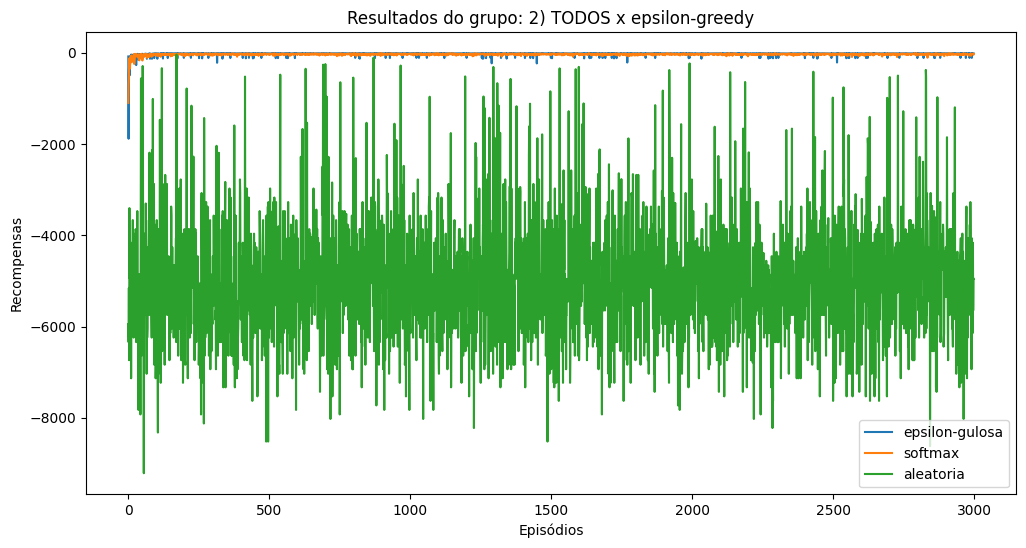


3) TODOS x softmax


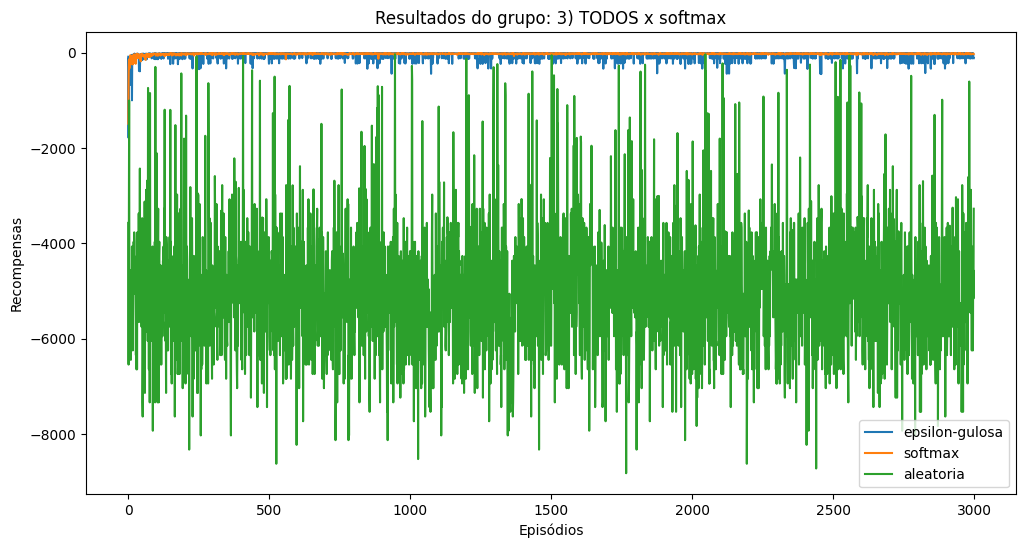


FINAL) Melhores de cada grupo


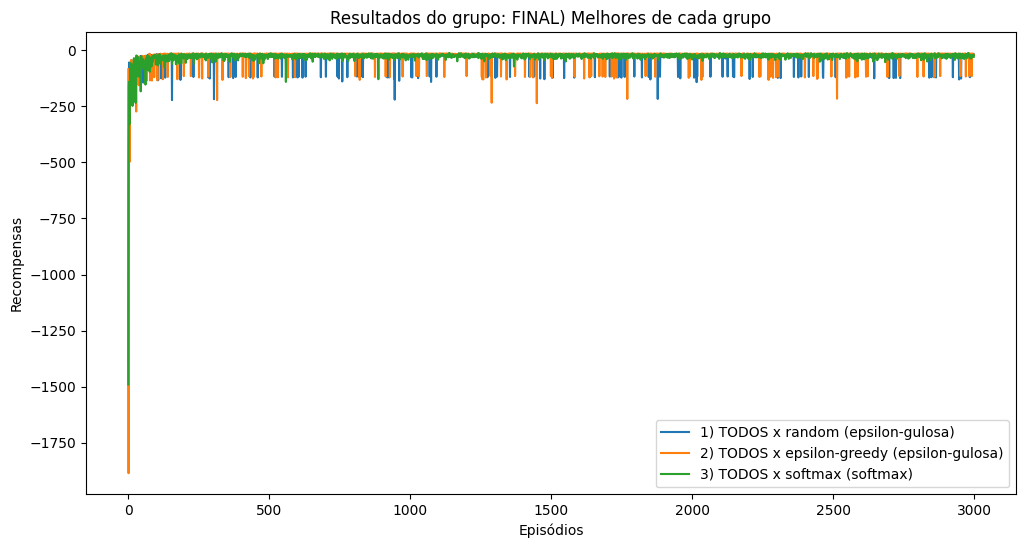

In [ ]:
# Plotar resultados
for grupo_nome, grupo_dados in resultados.items():
        print(f"\n{grupo_nome}")
        plot_multiple_results({grupo_nome: grupo_dados}, log_scale=False)